# Mining TripAdvisor users opinions about restaurants

#### In this section of the project, it will be extracted the sentiments of the reviews for each restaurant, using Natural Language Processing (NLP) tools for Python.

## Part 1: Extracting the text data

In order to perform a sentiment analysis in any text data it is necessary to have this text data in an appropriate form.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pymongo

import time
import datetime as dt
%matplotlib inline

In [2]:
# Oppening the MongoDB Altas Connection
f = open('/media/michel/dados/Projects/emails.txt', 'r')
passwd = f.read().splitlines()[2]
my_mongo_url = passwd

# Creating a Client
client = pymongo.MongoClient(my_mongo_url, serverSelectionTimeoutMS=5000)
db = client.restaurant_reviews

# Testing connection
db.reviews_I.find_one()

{'_id': ObjectId('6122570ffbd547706864808a'),
 'restaurant_name': 'Camarada Camarão - Shopping Recife',
 'rating': 5.0,
 'number_of_ratings': 3792,
 'review_title': 'Encontro amigos!',
 'review_date': 'Publicada ontem',
 'reviewer_Name': 'karolrevoredoo',
 'review': 'O ambiente é maravilhoso! E o atendimento do garçom Edvaldo é incrível, muito atencioso e solicito! O Gerente Amaro Rocha é muito cordial!',
 'reviews_scores': {'Excellent': 3073,
  'Very Good': 556,
  'Good': 63,
  'Bad': 19,
  'Terrible': 15}}

In [4]:
some_reviews = db.reviews_I.find({}).limit(5)
for review in some_reviews:
    print(review)

{'_id': ObjectId('6122570ffbd547706864808a'), 'restaurant_name': 'Camarada Camarão - Shopping Recife', 'rating': 5.0, 'number_of_ratings': 3792, 'review_title': 'Encontro amigos!', 'review_date': 'Publicada ontem', 'reviewer_Name': 'karolrevoredoo', 'review': 'O ambiente é maravilhoso! E o atendimento do garçom Edvaldo é incrível, muito atencioso e solicito! O Gerente Amaro Rocha é muito cordial!', 'reviews_scores': {'Excellent': 3073, 'Very Good': 556, 'Good': 63, 'Bad': 19, 'Terrible': 15}}
{'_id': ObjectId('61225710fbd547706864808c'), 'restaurant_name': 'Camarada Camarão - Shopping Recife', 'rating': 5.0, 'number_of_ratings': 3792, 'review_title': 'Ótima experiência', 'review_date': 'Publicada há 2 dias', 'reviewer_Name': 'Leticia C', 'review': 'Muito bem atendidos pelo Ângelo Atendimento ágil, simpático e prato muito saboroso Restaurante do shopping Recife Recomendamos', 'reviews_scores': {'Excellent': 3073, 'Very Good': 556, 'Good': 63, 'Bad': 19, 'Terrible': 15}}
{'_id': ObjectId

So, to extract only the review text of each document:

In [5]:
some_reviews = db.reviews_I.find({}).limit(5)
for review in some_reviews:
    print(f'Review: {review["review"]}\n')

Review: O ambiente é maravilhoso! E o atendimento do garçom Edvaldo é incrível, muito atencioso e solicito! O Gerente Amaro Rocha é muito cordial!

Review: Muito bem atendidos pelo Ângelo Atendimento ágil, simpático e prato muito saboroso Restaurante do shopping Recife Recomendamos

Review: Comida fantástica, muito bem servida e ambiente extremamente agradável. Garçons muito educados e super atenciosos.

Review: Culinária de frutos do mar impecável. Camarão ao Gergelim delicioso. Atendimento de Mayara excelente. Ambiente decorado com muito cuidado.

Review: Nota 10, atendente muito simpática e prestativa, chamava Nayara. Ambiente super aconchegante e a comida muito boa



Now we turn our attention to extracting some value from this reviews.

### 4. What are the most common words in the reviews titles?

In order to answer that question it will be necessary to concatenate all the reviews titles in one string and then perform a Term Frequency count in those words.
First we extract all the reviews titles from the data base and store in a list:

In [6]:
# Concateneting all the reviews titles in one string
# This process can take some time. Maybe it is a good ideia to measure it
words = []
all_reviews = db.reviews_I.find({})

st = time.monotonic()
for review in all_reviews:
    words.append(review["review_title"])
    
et = time.monotonic()
det = dt.timedelta(seconds = et - st)
print(f"Total processing time: {det}.")
print(f"Found {len(words)} titles")

Total processing time: 0:00:08.328496.
Found 30746 titles


And then we join everything together in a string.


In [8]:
# And now concatenating the reviews
titles = ' '.join(words)
print(titles[:100])

Encontro amigos! Ótima experiência Almoço Almoço casal Nota 10 Excelente para qualquer ocasião Almoç


#### Now our Natural Language processing starts. First we have to import all the necessary tools.

In [7]:
# Now importing the NLP toolkit 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

The first step when proceding with a NLP is to transform the data. First, we have to remove the stop words from the text. That can me made with the stopwords() function from the Natural Languague Processing Toolkit. Since the text is in portuguese language, we will have to specify it as an argument.

In [8]:
# Show the portuguese stopwords
print(stopwords.words('portuguese'))

['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estiv

Now let's remove these stopwords from the titles

In [9]:
# Instantiating the stopwords
stop_words = set(stopwords.words('portuguese'))
stop_words.update(["!", ".", ","])               # Removing some punctuations

# Spliting the big string into its words
titles_tokens = word_tokenize(titles)

# Using list comprehension to create a new list without the stopwords
filtered_titles = [title.lower() for title in titles_tokens if not title.lower() in stop_words]

Basically, this procedure is checking if a word in title *titles_tokens* is not in the *stop_words* list. If it is not, then it will be added to our *filtered_titles* list. The result in a bag of words.

Now we can generate a wordcloud to visualize the most common words in the reviews titles:

In [10]:
titles_cloud = WordCloud(max_words=50,
                         background_color='white',
                         prefer_horizontal=0.5,
                        width=800,
                        height=400,
                        colormap='Greens').generate(' '.join(filtered_titles))

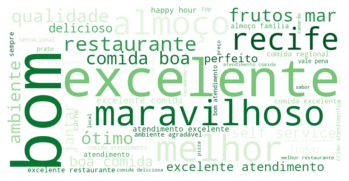

In [11]:
plt.imshow(titles_cloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud1.png')

Great! This word cloud shows us that the majority of the reviews titles relates to the rating of the restaurant. Being "Excellent" the title most attributed to the user experience. Then comes "Good", "Best", "Wonderful". The other group of titles relates to the type of meal that users were having, like "Lunch" and "Dinner".
It is also possible to create a bar plot to show the exact frequency of the words. For that, we have to count the frequency of each word, also known as Term Frequency.

In [12]:
# Let's calculate Term Frequency manually
TF = []

# This loop itereates through the set of filtered titles. A set is a data structure that stores only unique values
# It calculates how many each unique word appears in the filtered_titles
for word in set(filtered_titles):
    TF.append(filtered_titles.count(word))

# Transforming the set of unique words into a list
terms = list(set(filtered_titles))

As there are a lot of words, lets only use the words with frequency more than 500, for example.

In [13]:
min_freq=500

# Filtering only the frequencies bigger than min_freq
top_500_frequencies = [tf for tf in TF if tf > min_freq]

In [14]:
# Now filtering only the terms that correspondes do the top_500_frequencies
top_500_terms = []

# This loop iteretes over the terms list, and for each index of the terms list, it checks if the term with the same
# index in the TF is bigger than the min_freq. If it is, then it will be added to the new list
for j in range(len(terms)):
    if TF[j] > min_freq:
        top_500_terms.append(terms[j])

Lets print some sample values to see what is going on

In [15]:
for k in range(10):
    print(f'{top_500_terms[k]}: {top_500_frequencies[k]}')

melhor: 1548
bom: 2952
agradável: 732
qualidade: 613
jantar: 1348
ótima: 607
mar: 505
maravilhoso: 719
ambiente: 908
ótimo: 1106


And now lets visualize the terms that appears more than 500 in the reviews titles

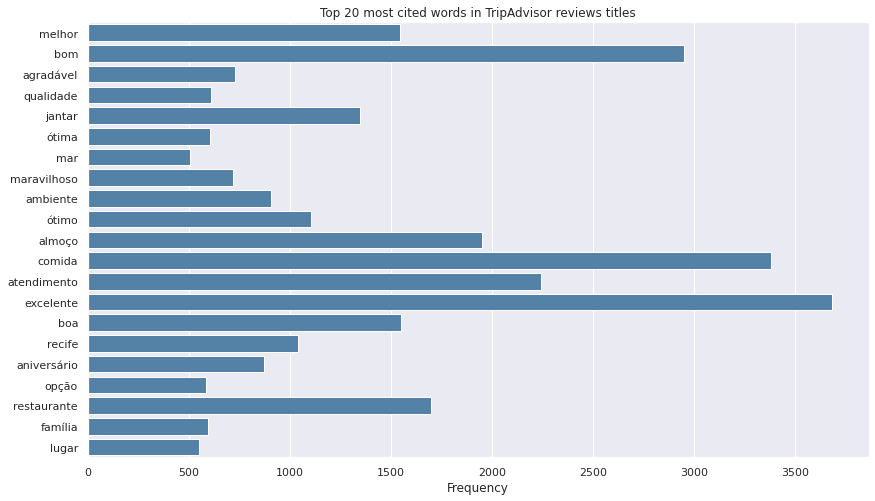

In [16]:
sns.set_theme('notebook')
fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(y=top_500_terms,
            x=top_500_frequencies,
           color='steelblue')
ax.set(title='Top 20 most cited words in TripAdvisor reviews titles',
       xlabel='Frequency')
plt.show()

There is a easier way to do that, all we have to do is create a dataframe and then we can easily plot graphs and sort values.

In [17]:
# Creating a dataframe out of lists
df_tf = pd.DataFrame(data=list(zip(terms, TF)), columns=['Term', 'Frequency'])
df_tf.sort_values(by='Frequency', ascending=False)

,Term,Frequency
3192,excelente,3682
2819,comida,3380
172,bom,2952
3061,atendimento,2244
2785,almoço,1952
...,...,...
1370,junino,1
1369,relacionamento,1
3225,cachorro-quente,1
1368,aa,1


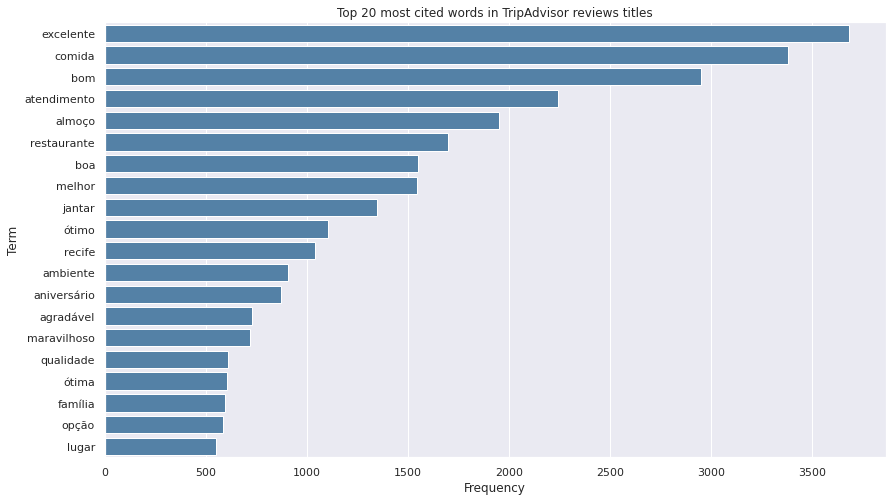

In [18]:
# Now lets redo the bar plot showing the top 20 words
df_tf_top_20 = df_tf.sort_values(by='Frequency', ascending=False)[:20]
fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(data=df_tf_top_20,
           x='Frequency',
           y='Term',
           color='steelblue',
           )
ax.set(title='Top 20 most cited words in TripAdvisor reviews titles',
      xlabel='Frequency')
plt.show()

That answers our forth question.

### 5. What are the most common words in the reviews texts?
To answer that question we can follow the same path as we did in the reviews titles. But now let's first apply the Sentiment Analysis to the reviews and split apart the positive reviews from the negatives and from the neutral reviews.
To reach that, lets create a dataframe that stores each review text in row. Then, we extract the sentiment and store it in another column. This way we can filter between each of the sentiments.

#### Creating a DataFrame with all the reviews texts
Lets rerun the query that retrieves all the reviews texts

In [19]:
# Querying the database
all_reviews = db.reviews_I.find({})

# Create a empty list to store the text
reviews = []

# Iterate over the cursor do extract the review
for review in all_reviews:
    reviews.append(review['review'])

# Show a sample result
reviews[:10]

['O ambiente é maravilhoso! E o atendimento do garçom Edvaldo é incrível, muito atencioso e solicito! O Gerente Amaro Rocha é muito cordial!',
 'Muito bem atendidos pelo Ângelo Atendimento ágil, simpático e prato muito saboroso Restaurante do shopping Recife Recomendamos',
 'Comida fantástica, muito bem servida e ambiente extremamente agradável. Garçons muito educados e super atenciosos.',
 'Culinária de frutos do mar impecável. Camarão ao Gergelim delicioso. Atendimento de Mayara excelente. Ambiente decorado com muito cuidado.',
 'Nota 10, atendente muito simpática e prestativa, chamava Nayara. Ambiente super aconchegante e a comida muito boa',
 'Excelente o gratinado imperial!!! Dá pra três pessoas que não comem muito tranquilo. Atendimento também é bom e o ambiente é bem bonito.',
 'Excelente!! Luciana atende com dedicação e atenção, uma querida!! Amaro Rocha muito atencioso e tomando conta do atendimento o tempo todo. Parabéns ao Camarada Camarão do shopping Recife!!',
 'O Camarada

And now we add that to a new dataframe

In [20]:
reviews_df = pd.DataFrame(reviews, columns=['review'])
reviews_df.head()

,review
0,O ambiente é maravilhoso! E o atendimento do g...
1,Muito bem atendidos pelo Ângelo Atendimento ág...
2,"Comida fantástica, muito bem servida e ambient..."
3,Culinária de frutos do mar impecável. Camarão ...
4,"Nota 10, atendente muito simpática e prestativ..."


Now let's start with the Natural Language processing procedure. First and foremost, import the libraries

In [21]:
from textblob import TextBlob
import re

The sentiment analysis will not work well in the portuguese language, so let's try to translate it to english. The result may not be the best, but give it a try.

In [22]:
# pip install googletrans==4.0.0-rc1
from googletrans import Translator, constants

In [24]:
translator = Translator()
def translate_reviews(row):
    """
    This function translates a review from the original
    languague (portuguese in this case)
    to english
    """
    try:
        translated_review = translator.translate(row).text
        return translated_review   
    
    except:
        print(f"something went wrong with the frase: {row}---")

In [25]:
st = time.monotonic()
reviews_df['text'] = reviews_df['review'].apply(translate_reviews)
et = time.monotonic()
td = dt.timedelta(seconds = et - st)
print("Processing Time: ", td)
reviews_df.to_csv('reviews_df.csv', index=False)

something went wrong with the frase: Atendimento muito bom, atendente muito simpática a Juliana Karla. Tudo ótimo. Indico muito se vc estiver aqui nas redondezas do shopping recife provar.---
something went wrong with the frase: Gostei muito dorestaurante, excelente atendimento do garçom lenilson e o metri Robson, espaço muito agradável.---
something went wrong with the frase: Atendimento excelente do Valbens. Comida maravilhosa, carne super macia e tempero excelente. Voltarei sempre.---
something went wrong with the frase: Serviço de Ícaro e do senhor Lima são excelente! Podem procurar por eles. Ambiente muito aconchegante e a cerveja sempre gelada.---
something went wrong with the frase: Ótimo atendimento do Ikaro!! Cerveja gelada, ambiente agradável, eu quero vim sempre aqui e ser atendido pelo Ikaro.---
something went wrong with the frase: Eles são topa principalmente Ícaro e sei Lima os dois precisam ser promovidos, fui atendida da melhor forma possível---
something went wrong wit

something went wrong with the frase: Oi Malu!! Ficamos felizes por termos agradado a sua preferência. As suas observações serão muito bem avaliadas. Agradecemos a sua escolha e esperamos poder recebê-la aqui novamente na casa do Bodinho, será muito bem-vinda!---
something went wrong with the frase: De frente à praia de Olinda/PE, fui almoçar com a família no Bode do Nô. Fui muito bem recebido pelos funcionários atenciosos, sentamos e logo a comida foi servida, deliciosa a um preço justo. Recomendo aos viajantes, vale a pena!---
something went wrong with the frase: Pela segunda vez estive no Bode do Nô de Boa Viagem e o sentimento foi o mesmo da primeira vez: um lugar amplo, agradável, bem estruturado, com um vasto cardápio, cujo atendimento e qualidade dos pratos destoam do ambiente. Garçons mal humorados, prato com qualidade...Mais---
something went wrong with the frase: Conhecemos o restaurante pelas redes sociais e quando viajamos pra Recife fomos conhecer,amamos o ambiente super ac

something went wrong with the frase: Tudo muito bom e a comida espetacular... Antonio, melhor garçom!!Super recomendo, ambiente muito agradavel com criancas inclusi e!!---
something went wrong with the frase: Agradecemos sua visita e avaliação. Ficamos muito felizes por termos atendido suas expectativas. Aguardamos sua próxima visita.---
something went wrong with the frase: Bom demais! O bode é show de bola. Fomos atendidos por Eliomar. Muito gentil o garçom. Voltaremos com certeza.---
something went wrong with the frase: Agradecemos sua visita e avaliação. Ficamos muito felizes por termos atendido suas expectativas. Aguardamos sua próxima visita.---
something went wrong with the frase: Tem que ir lá. Bem localizado, com estacionamento, em frente ao mar. Comida nordestina, lugar muito bem decorado, muitas opções de refeições ou porções. Bom atendimento. Boa comida. Bom lugar. O que mais precisa? Preços condizentes com o que é oferecido. Com certeza volto lá.---
something went wrong wit

something went wrong with the frase: Agradecemos sua visita e avaliação. Ficamos muito felizes por termos atendido suas expectativas. Aguardamos sua próxima visita.---
something went wrong with the frase: Restaurante bonito, bem movimentado, com ótimas opções para quem quer experimentar o bode. Recomendo.---
something went wrong with the frase: Agradecemos sua visita e avaliação. Ficamos muito felizes por termos atendido suas expectativas. Aguardamos sua próxima visita.---
something went wrong with the frase: Uma culinária bem regional, porém muito sofisticado. Com sobremesas deliciosas que enchem aos nossos olhos.---
something went wrong with the frase: Agradecemos sua visita e avaliação. Ficamos muito felizes por termos atendido suas expectativas. Aguardamos sua próxima visita.---
something went wrong with the frase: Local agradável, bem recomendado pelo nosso representante, porém esperava mais do local. Chopp não estava no ponto, porém o atendimento foi bom.---
something went wrong 

something went wrong with the frase: Sr. José Carlos, ver nossos clientes satisfeitos é nossa maior meta e sempre faremos tudo que está ao nosso alcance para entregar um trabalho impecável. Obrigado!---
something went wrong with the frase: Comida deliciosa, ambiente aconchegante, bons e variados drinks. Além de contar com um bom atendimento!---
something went wrong with the frase: Sra. Joana, foi um prazer receber sua visita. Esperamos que tenha gostado e que a qualidade do nosso trabalho justifique uma próxima visita. Até breve!---
something went wrong with the frase: excelente restaurante, com boas opções de comidas e com uma carta de drinks e vinhos muito bem escolhida.---
something went wrong with the frase: Sr. Paulo, é uma enorme alegria saber que depositou em nós sua confiança e que viu no trabalho que desempenhamos algo que ia de encontro às suas necessidades. Muito obrigado.---
something went wrong with the frase: Ambiente aconchegante e serviço exemplar. Fomos muito bem receb

something went wrong with the frase: Vlw Renato! obrigado pelo feedback!---
something went wrong with the frase: Produtos deliciosos, bom atendimento e entrega pontual e entregador atencioso e simpático. O ponto físico é aconchegante e familiar. E o melhor: preço excelente.---
something went wrong with the frase: Obrigado pelo feedback Lidia! procuramos sempre dar o melhor de nós no atendimento e avaliacoes como a sua nos fazem a fazer cada vez sempre o melhor!---
something went wrong with the frase: Comida maravilhosa, excelente entrega e atendimento. Tudo no precinho e com qualidade, todo mundo adorou---
something went wrong with the frase: Obrigado pelo feedback Eduarda! qualidade é o nosso foco!---
something went wrong with the frase: Hambúrgueres deliciosos,com um bom atendimento.(entrega dentro do horário previsto) E para quem quer ir direto a bigode lanches é um ambiente aconchegante bem família.---
something went wrong with the frase: Obrigado pelo feedback! procuramos sempre o

something went wrong with the frase: Levamos nossos amigos canadenses para saborear alguns pratos típicos da nossa cozinha. No self Service variado provamos pratos deliciosos excelente sobremesas. Vale a pena esperar a fila e se deliciar nesse sabor 😋---
something went wrong with the frase: Sem dúvida, o melhor self-service de Boa Viagem. Comida caprichada, sempre de melhor qualidade, Decoracao linda, atendimento excelente. Não é barato, mas a comida vale a visita. Não deixe de experimentar a salada de manga 😋---
something went wrong with the frase: Um bom restaurante, com opções bem variadas pra quem tem restrições, tem sopas e muitas saladas, comida muito gostosa, lugar muito bonito e aconchegante, preço meio salgado!---
something went wrong with the frase: A comida é bem saborosa e o buffet possui opções diversificadas. O preço é médio. Várias opções de salada.---
something went wrong with the frase: Muitíssimo boa comida. Considero um dos melhores self services do Brasil.Tudo é de 

something went wrong with the frase: Todos (4) muito satisfeitos com o que comeram. Ambiente climatizado e com bela decoração. Preço justo.---
something went wrong with the frase: Fomos sábado almoçar e provamos muita coisa , o filé , a picanha e até frutos do mar, acompanhados de muito verde e um arroz com brócolis maravilhoso.---
something went wrong with the frase: Sem dúvida, o Chica Pitanga tem a maior e melhor variedade de pratos na modalidade self service em Boa Viagem. Pratos requintados e deliciosos explicam a espera por uma mesa no restaurante nos fins de semana.---
something went wrong with the frase: Bem proximo a praca este restaurante impressionou pela simpatia e qualidade da comida. Otimo tempero e estilo self sevice. Preco um pouco alto mas vale pela produto oferecido.---
something went wrong with the frase: Nova visita a Recife. Hospedado em Boa Viagem, convite para almoçar no Chica Pitanga. Vale cada moeda. Atendimento muito simpático já na recepção. O mesmo da equipe

something went wrong with the frase: Prós: 1 - Comida muito bem feita e ingredientes de excelente qualidade. 2 - Restaurante totalmente climatizado e agradável. (Sala da Fila de espera com ar condicionado) 3 - Atendimento simpático. 4 - Decoração inusitada e divertida. 5 - Fácil localização. Contras: 1 - Preço...Mais---
something went wrong with the frase: O local é magnífico, a comida é maravilhosa; acho ser o melhor de Recife. O local e o atendimento são nota 10.---
something went wrong with the frase: comida variada e muito saborosa. Por ser por quilo é uma ótima opção para o almoço em boa viagem. Apesar da fila de espera, fomos chamados em menos de 20 minutos.---
something went wrong with the frase: O restaurante é de fácil acesso. Além disso, a comida é espetacular com uma variedade sensacional. Temperatura ideal. O atendimento é muito bom! Imperdível!!!---
something went wrong with the frase: Restaurante bem bonito, comida variada e gostosa! Fica em boa viagem, fácil acesso. Preç

something went wrong with the frase: Lugar agradável, boa variedade de comida, bom atendimento. Preço um pouco alto, mas compensa pelo que oferece. Uma boa pedida em Recife!---
something went wrong with the frase: Restaurante self service com comida variada e saborosa. O salão é bem decorado, porém o atendimento bem fraco. Vale conhecer para uma refeição rápida. Achei o preço justo.---
something went wrong with the frase: A comida sempre espetacular faz valer a pena a viagem até Recife. Como gosto de comer bem e ser bem atendido Recomendo muito, especialmente no almoço---
something went wrong with the frase: Excelente ...RECOMENDO! Qualidade de saladas e carnes com preco justo. Otima localizacao...muita variedade---
something went wrong with the frase: Self service de alto padrão com comidas requintadas e excelentes combinações. Risotos, bobó de camarão, peixes, carnes...tudo de primeira qualidade. O preço é um pouco alto mas vale a pena. Fui num domingo com os amigos e todos nós gosta

something went wrong with the frase: Chegamos no aeroporto na hora do almoço. Antes de viajar para maracaipe decidimos almoçar em Recife. O restaurante surpreendeu. Comida boa e de qualidade. Valor não é barato mas compensa. Recomendo e voltaria com certeza---
something went wrong with the frase: Tradicional self-service da zona sul da cidade, Chica Pitanga não perdeu em nada a qualidade de seu período de ouro. No coração da zona sul da cidade, o restaurante oferece comida de boa qualidade para refeições familiares e de negócios.---
something went wrong with the frase: Restaurante com uma culinária maravilhosa. Tem comida regional, saladas, frutos do mar... Tudo muito gostoso. O preço é salgado...---
something went wrong with the frase: O restaurante e ótimo e os funcionários muito atenciosos. Buffet com saladas, pratos quentes e sobremesas. Comemos muito bem.---
something went wrong with the frase: Ambiente aconchegante, comida saborosíssima, atendimento muito bom..... adoramos!!!Volt

something went wrong with the frase: A variedade é suficiente para agradar todos os gostos, saladas diversas, iguarias regionais, frutos do mar, carnes, e produtos integrais. Tudo muito saboroso. Adoro---
something went wrong with the frase: Com um vasto buffet, sopas e sucos naturais e sobremesas este é um lugar excelente para fazer uma boa refeição perto da praia!---
something went wrong with the frase: Com frequência estou neste maravilhoso self-service.Tudo muito bom. Os pratos são bastante apetitosos e possuem grande variedade. A acolhida destaca-se pela simpatia das moças na entrada do Restaurante. A decoração típica é incomum. As instalações são cuidadosamente limpas e a apresentação dos pratos organizada. Serviços...Mais---
something went wrong with the frase: Bom lugar para refeições, muita variedade de pratos, bom atendimento. Sobremesas excelentes. Preço compatível com o que se oferece. Vale ligar antes para saber o tamanho da fila. Recomendo.---
something went wrong with th

something went wrong with the frase: Bem localizado o restaurante oferece variada opções de saladas, frutos do mar e caldos. Há boa comida para todos os paladares. Serviço bom e atendentes simpáticas. Peca pelo café expresso de baixa qualidade.---
something went wrong with the frase: Muito bom. Excelente o bobó de camarão, peixe, escondidinho, salada de manga... self Service. Preços variados para os pratos classificados por grupos.---
something went wrong with the frase: Comida deliciosa, decoração diferente e interessante. Próximo da feira de Boa viajem, chegamos caminhando, não precisa de carro.---
something went wrong with the frase: Aqui é a copa da cozinha da minha casa!! Era perto da minha casa e sempre convidava os amigos ou as pessoas para negócios neste restaurante aconchegante com comidas saborosas de muita variedade.---
something went wrong with the frase: Este restaurante foi um surpresa muito boa na minha viagem. Um excelente resutarante. Comidas saborosas e com preço just

something went wrong with the frase: Muitas opções no jantar, incluindo saladas, massas e pratos regionais, como munguzá, escondidinho e o famosos bolo de rolo pernambucano. Vale ressaltar o cuidado em advertir na apresentação de alguns pratos que os mesmos contêm lactose, pois se tratando de comidas nordestinas, muitas delas são...Mais---
something went wrong with the frase: Almoçamos nesse restaurante, pois estava muito bem avaliado aqui no TripAdvisor. Entretanto, o custo benefício não entendemos ser bom. O valor do quilo aos finais de semana é muito acima do que é entregue no buffet. Existem melhores opções em Recife.---
something went wrong with the frase: Comida boa e com boa variedade. Sucos naturais. E pros intolerantes a lactose, todos os pratos do buffet informam se contém ou não lactose. Minha esposa agradece! Tem até sorvete sem lactose!---
something went wrong with the frase: Todas as vezes que vou á Recife enho que almoçar no Xica pitanga... Uma comida maravilhosa e sem f

something went wrong with the frase: Em um ambiente super agradável, esse restaurante á peso, existe há mais de 10 anos sempre com a mesma qualidade excelente.Farto na variedade de saladas, comida regional e diversas e sobremesas maravilhosas.Recomendo muito!---
something went wrong with the frase: Comida sensacional, muito acima da média! No dia que fui tinha 4 tipos de peixes, camarão preparados de diversas formas. Destaco o Camarão Imperial, melhor comida que ja comi.---
something went wrong with the frase: Simplesmente Maravilhoso! Comida saborosa, atendimento fantástico. Cardápio bem diversificado, Super recomendo😉---
something went wrong with the frase: Ambiente fino, decoração harmoniosa e bem planejada, agradável para o comensal. Das saladas às monstruosas sobremesas (deviam ser contra a lei) o Chica Pitanga oferece um buffet requintado e de qualidade gastronômica. A atenção aos detalhes vigora em todos os momentos, o serviço atento e...Mais---
something went wrong with the fra

something went wrong with the frase: Lugar charmoso, com uma boa comida variedade de pratos e saladas além dos caldinhos. Com opções variadas de sobremesa da culinária local.---
something went wrong with the frase: Excelente! A variedade e a qualidade da comida são excelentes! E o atendimento também! Super indico!---
something went wrong with the frase: Lugar agradável, confortável e diferente! Foi uma experiencia super legal, adorei a decoração do ambiente, ficamos encantados!---
something went wrong with the frase: Comida deliciosa!! Muita variedade. Experimentem o suco de morango com tangerina, que vale muito a pena! (apesar do preço ser um pouco alto)---
something went wrong with the frase: Excelente restaurante do tipo serve self, com uma boa comida e variedade, muito bem frequentado e preço razoável(não é tão barato), mas vale a pena almoçar lá.---
something went wrong with the frase: O Chica Pitanga é famoso em Boa Viagem por seu buffet diversificado e delicioso (inclusive as so

something went wrong with the frase: Excelente opção para quem procura um self-service. A comida é muito saborosa. Nesse self - service você vai encontrar uma ótima variedade de carnes e frutos do mar. As sobremesas são de dá agua na boca!---
something went wrong with the frase: Um lugar ao mesmo tempo aconchegante e sofisticado, no qual podemos ter um encontro de amigos como um jantar romântico.---
something went wrong with the frase: Vale a pena conhecer, se estiver com $ pra gastar, pois há uma vasta variedade de pratos regionais, inclusive de frutos do mar. Almoço e Jantar.---
something went wrong with the frase: Lugar bonito e aconchegante, pratos deliciosos , bem variados no sistema buffet a kilo, ingredientes de qualidade, tudo que eu experimentei estava gostoso. Preço medio para alto, mas vale a pena---
something went wrong with the frase: Recomendo a todos que estiverem em Pernambuco, passar no Chica Pitanga, é meio caro (em torno de R$ 69,00/KG), mas vale a pena.---
something

something went wrong with the frase: Um dos melhores self service que já fui. Ambiente confortável e comida super bem feita com preços justos. Adoro ir lá!---
something went wrong with the frase: Restaurante a quilo. Comida regional. O buffet de opçōes nāo é grande, mas tudo é de bom gosto. Nunca encontrei alguém que nāo faça elogios. Nota 10. Recomendo.---
something went wrong with the frase: Excelente comida, boa variedade e pratos diferenciados. Sem dúvida alguma é o melhor self service da cidade. A língua e o bacalhau são espetaculares. Pena que só aceitem cartão Visa.---
something went wrong with the frase: Após um dia cheio, de muita caminhada no sobe e desce das ladeiras de Olinda e de muita comilança, resolvemos a noite fazer uma refeição mais leve, chegamos ao Restaurante Chica Pitanga, self service a quilo para todos os gostos, desde a simples salada até...Mais---
something went wrong with the frase: Apesar da quantidade de pessoas na lista de espera, fomos muito bem atendido

something went wrong with the frase: Chica Pitanga oferece muitas opções de comida a peso. Possui também sobremesas light e diet. A oferta de saladas, legumes e grãos é muito importante para quem é vegetariano, como eu, apesar de não ser um restaurante com essa finalidade. No item carnes, peixes, aves...Mais---
something went wrong with the frase: Comida muito boa tipo self service , tinha bastante variedade a localização é boa tbm, as sobremesas são gostosas e com opções de tortas, muito bom.---
something went wrong with the frase: Lugar lindo e aconchegante, o Chica Pitanga oferece o sistema de self serviço mas com opções de comidas caseiras muito gostosas e alguns pratos típicos nordestinos. Atendimento impecável!!! Não deixe de tomar o suco de graviola e provar o caldo de cenoura com alho poró....Mais---
something went wrong with the frase: Boa variedade misturando comida típica e as tradicionais. Sucos saborosos . Preço poderia ser mais acessivel---
something went wrong with the f

something went wrong with the frase: Muita variedade e tudo muito gostoso. Considero o melhor self service do Recife. Só não frequento mais por ser distante do meu bairro. O preço é acima da média, mas a qualidade compensa o maior custo. Chegue cedo, pois sempre tem fila.---
something went wrong with the frase: A comida parece ser muito gostosa. Digo parece pois, cheguei ao restaurante perto das 22h (horário que fecha), a recepcionista me deixou entrar sem nenhum aviso de que o restaurante estava fechando e que logo iriam recolher o buffet... Quando comecei a me servir, o...Mais---
something went wrong with the frase: Restaurante extremamente aconchegante, comida variada e saborosa, com bela decoração regional e um destaque para a grandiosa e genial releitura de uma pitangueira no centro do ambiente, fazem dele um diferencial dentre os demais restaurantes da cidade do Recife. Baseado na conjugação da culinária portuguesa,...Mais---
something went wrong with the frase: Muito bom!!!! Ado

something went wrong with the frase: Almocei num domingo no restaurante, o que posso dizer é que o ambiente é muito agradável, bem decorado e conta com uma boa gama de opções no self-service, apesar de ter bastante frutos do mar e eu não ser muito fã, por isso não posso...Mais---
something went wrong with the frase: O Buffet a kilo tem várias opções tudo muito gostoso, e dificil nao experimentar de tudo. A fila de espera e grande mas anda rápido. Com certeza é um bom restaurante. Nao tem espaço para crianças e um restaurante para saborear a comida e nada...Mais---
something went wrong with the frase: Fomos para um jantar rápido. Comida boa e variada, mas nada demais. Não aceitam cartões da bandeira master---
something went wrong with the frase: gostoso de entrar no almoço e jantar, cuidadosos com a variedade e clean e charmoso a diversidade em temperos pra agradar é bem legal de se encontrar da entrada , sopas, torradas, saladas, pratos variados e sobremesas delicia em tudo---
somethin

something went wrong with the frase: Conhecemos o restaurante em abril/14. Como retornamos a Recife em janeiro último, foi impossível não retornar ao restaurante pois a alimentação é muito gostosa, bem preparada e apresentada. Sem falar, é claro, no custo benefício que é excelente.---
something went wrong with the frase: Mesmo sendo frequentador contumaz desse estabelecimento, noto que melhoram a cada dia, seja na variedade, seja no atendimento. Imperdivel---
something went wrong with the frase: A melhor comida do Recife. Restaurante agradável, que nos faz mudar o conceito de comida a quilo. Simplesmente divino ao paladar e ao olhar.---
something went wrong with the frase: Adorei o restaurante Chica Pitanga de Recife. Pratos maravilhosos, recomendo experimentar, além dos outros, a salada de polvo e as tortas doces de nozes e rocambole de laranja. O buffet é a quilo, mas não é muito caro, além de ser um ambiente bastante agradável.---
something went wrong with the frase: Restaurante com

something went wrong with the frase: o melhor do Recife, perfeito na variedade e na qualidade, as saladas são maravilhosas e os pratos de carne, eu só como língua no chica pitanga, é excelente, pena que é muito concorrido e tem fila de espera sempre, mas vale a pena a espera.---
something went wrong with the frase: Um restaurante no bairro de Boa Viagem em Recife que fica muito próximo dos principais hotéis do bairro e com comida de excelente qualidade. Muito aconchegante.---
something went wrong with the frase: O restaurante fica localizados perto da praça da boa viagem, esta sempre cheio, chegando depois do meio dia sempre em fila, tem lugar de espera sentado, a comida é deliciosa com uma variedade saladas, pratos quentes e sobremesas saborosas, ar condicionado, Aceita cartões de crédito...Mais---
something went wrong with the frase: Restaurante self service em Boa Viagem muito legal, boa comida, ambiente agradável e gente bonita. Fica próximo a praia e uma feirinha de artesanatos. G

something went wrong with the frase: Excelente comida , ambiente e um preço bastante justo . Vale a pena conferir e deixar um espaço para a sobremesa que também é excelente .---
something went wrong with the frase: Restaurante self service, para quem gosta desse tipo de serviço, pode-se considerar um bom restaurante. Há pratos típicos e diversas variedades.---
something went wrong with the frase: Restaurante bem localizado na praia de boa viagem, bem próximo a praia, com variedade no cardápio e custo benefício justo! Estilo Self-service, com variedades de carnes, frutos do mar, saladas e massas.Vale a pena conferir, por isso recomendo!---
something went wrong with the frase: É disparado o melhor restaurante self-service da redondeza. Tem uma variedade incrível, que certamente agradará a todos os gostos. A decoração é uma atração a parte.---
something went wrong with the frase: Restaurante muito agradável, estive lá para jantar e fiquei impressionado com a qualidade do ambiente e da com

something went wrong with the frase: Ficamos aguardando por mesa, mas o tempo estimado pela recepcionista que nos recebeu, foi cumprido, cerca de 15 minutos. Há variedade de comidas, saladas e molhos, que também estavam saborosos. A sobremesa que escolhi não seguiu o padrão das comidas.---
something went wrong with the frase: Comida diversificada, com excelente salada, boas opções de peixe, frango e carne bovina. bom atendimento. Falta estacionamento local.---
something went wrong with the frase: Restaurante climatizado e muito bem decorado a um quarteirão da praia de Boa Viagem. Comida a peso gostosa e variada - polvo, lula, camarão, carneiro, feijoada - que podem ser acompanhadas por um vinho, uma cerveja do cardápio de bebidas que inclui água mineral do...Mais---
something went wrong with the frase: Morei em Recife em 2008/9 e sempre ia ao restaurante. Estive visitando Recife em março e não pude deixar de ir ao restaurante. A comida estava muito boa como antigamente, porem no jantar

something went wrong with the frase: Restaurante que trabalha no sistema de buffet por quilo, com uma excelente variedade de pratos frios e quentes, inclusive com pratos da comida regional. A qualidade dos pratos é razoavelmente boa. Com exceção da hostess e da caixa, os outros funcionários não são amistosos, principalmente...Mais---
something went wrong with the frase: Trata-se de um restaurante "self-service" com grande variedade de pratos frios, quentes e sobremesas, ideal para quem não quer perder muito tempo cozinhando ou num restaurante à La Carte. A localização é boa, próxima à praça de Boa Viagem, abre para o almoço e para...Mais---
something went wrong with the frase: Já fui algumas vezes lá e me agrada bastante a grande variedade de pratos em oferta neste bom restaurante por quilo. Oferecem desde saladas, passando por massas, peixes e até carnes "exóticas". Sempre encontrei bons pratos de cordeiro e, principalmente, de frutos do mar. O...Mais---
something went wrong with the 

something went wrong with the frase: Boa localização,fila de espera,um pouco caro,mas a comida é de boa qualidade,garçons eficientes a unica coisa que nao gostei e que quando ficamos na fila de espera dps de uns 10 minutos fomos chamados com um cartao para a mesa,e a mesa estava suja e...Mais---
something went wrong with the frase: o restaurante é muito bom mesmo, comida nordestina de primeira qualidade, fica perto de bons hoteis e da praia, dá para depois do almoço dar uma passeada em frente ao mar de boa viagem!! detalhe para o molho de iogurte com morango para a salada!!!...Mais---
something went wrong with the frase: É um self service com uma boa variedade. Possui vários tipos de saladas. A comida é de excelente qualidade. O ponto negativo é só a fila de espera que é grande em dias de muito movimentos.---
Processing Time:  12:02:46.318050


In [26]:
reviews_df.head()

,review,text
0,O ambiente é maravilhoso! E o atendimento do g...,The setting is wonderful!And the service of th...
1,Muito bem atendidos pelo Ângelo Atendimento ág...,Very well attended by the Ângelo service agile...
2,"Comida fantástica, muito bem servida e ambient...","Fantastic food, very well served and extremely..."
3,Culinária de frutos do mar impecável. Camarão ...,Good seafood cuisine.Shrimp to the delicious s...
4,"Nota 10, atendente muito simpática e prestativ...","Note 10, very friendly and helpful attendant, ..."


Great! Now we have a translated text in 12 hours!

In [23]:
# Reading the processed dataframe
reviews_df = pd.read_csv('reviews_df.csv')

Before starting the sentiment extractation, we need to clean up the texts in order to extract punctuations and other characters that doe not have any sentiment content.

In [24]:
# Lets create a function that cleans the texts row by row

def clean_text(row):
    """
    this function removes any punctuation characters from the text
    and return the text in lower case.
    """
    clean_row = re.sub(pattern='[!\\.@\d,´`]',
                      repl='',
                      string=str(row)).lower()
    return clean_row

And now we apply the cleaning function, creating a new column with the cleaned text. This process is going to take a while, since we are using the Google Translator API. Lets register that time and save the dataframe into a .csv file for checkpoint.

In [25]:
reviews_df['processedText'] = reviews_df['text'].apply(clean_text)

In [26]:
reviews_df

,review,text,processedText
0,O ambiente é maravilhoso! E o atendimento do g...,The setting is wonderful!And the service of th...,the setting is wonderfuland the service of the...
1,Muito bem atendidos pelo Ângelo Atendimento ág...,Very well attended by the Ângelo service agile...,very well attended by the ângelo service agile...
2,"Comida fantástica, muito bem servida e ambient...","Fantastic food, very well served and extremely...",fantastic food very well served and extremely ...
3,Culinária de frutos do mar impecável. Camarão ...,Good seafood cuisine.Shrimp to the delicious s...,good seafood cuisineshrimp to the delicious se...
4,"Nota 10, atendente muito simpática e prestativ...","Note 10, very friendly and helpful attendant, ...",note very friendly and helpful attendant call...
...,...,...,...
30741,"Ótimo ambiente, e excelente atendimento fui no...","Great atmosphere, and excellent service I went...",great atmosphere and excellent service i went ...
30742,"Adoro o ambiente, os atendentes são simpáticos...","I love the environment, the attendants are fri...",i love the environment the attendants are frie...
30743,"Sempre bom, confiável, carnes maravilhosas, en...","Always good, trustworthy, wonderful meats, tas...",always good trustworthy wonderful meats tasty ...
30744,"Outback é maravilhoso em qualquer, lugar, conh...","Outback is wonderful in any, place, I know the...",outback is wonderful in any place i know the s...


Now we create another function that extracts the sentiment from the review row by row and adds to another column

In [28]:
def extract_sentiment_polarity(row):
    """
    This function uses the TextBlob
    class and extract the polarity of the sentiment
    """
    blob = TextBlob(row)
    polarity = blob.polarity
    return polarity

In [29]:
reviews_df['polarity'] = reviews_df['processedText'].apply(extract_sentiment_polarity)
reviews_df.head()

,review,text,processedText,polarity
0,O ambiente é maravilhoso! E o atendimento do g...,The setting is wonderful!And the service of th...,the setting is wonderfuland the service of the...,0.535833
1,Muito bem atendidos pelo Ângelo Atendimento ág...,Very well attended by the Ângelo service agile...,very well attended by the ângelo service agile...,0.318750
2,"Comida fantástica, muito bem servida e ambient...","Fantastic food, very well served and extremely...",fantastic food very well served and extremely ...,0.413333
3,Culinária de frutos do mar impecável. Camarão ...,Good seafood cuisine.Shrimp to the delicious s...,good seafood cuisineshrimp to the delicious se...,0.523333
4,"Nota 10, atendente muito simpática e prestativ...","Note 10, very friendly and helpful attendant, ...",note very friendly and helpful attendant call...,0.346167


In [30]:
# Saving the dataframe checkpoint again
reviews_df.to_csv('reviews_df.csv', index=False)

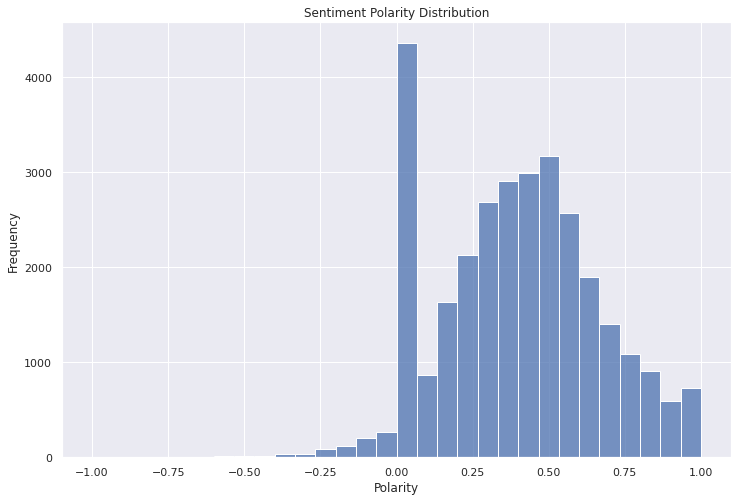

In [49]:
# Plotting the polarity distribution
fig, ax = plt.subplots(figsize=(12,8))
sent_dist = sns.histplot(data=reviews_df,
            x='polarity',
            bins=30)

ax.set(title='Sentiment Polarity Distribution',
      xlabel='Polarity',
      ylabel='Frequency')
plt.show()

fig.savefig('sent_dist.png')

The reviews sentiments follows a normal distribution centered at the 0.5! This means that in average, the review sentiments are just positive, with a smaller number of extremely positive reviews and slightly positive. We have a peak of neutral sentiments at 0, and some residual slightly negative sentiments. This is a interesting result, it seems that the majarity of peoples experiences with restaurants are pleasant. Also, the there is a peak in the reviews with sentiment polarity close to 0 positively. This tells us that a lot of the reviews does not carry any complement of complaining about the user experience. This reviews are probably just describing the experience in a neutral form.

Now let's split this dataframe into positive and negatives, so we can create a separated word cloud and see what is going on with those reviews.

In [42]:
neg_reviews = reviews_df[reviews_df['polarity'] < 0]
pos_reviews = reviews_df[reviews_df['polarity'] > 0]

neg_reviews.head()

,review,text,processedText,polarity
168,O restaurante é espetacular! Da bebida a comid...,The restaurant is spectacular!Drink the food !...,the restaurant is spectaculardrink the food in...,-0.600000
392,Já sou cliente da rede Camarada há um bom temp...,I've been a client from the companion network ...,i've been a client from the companion network ...,-0.014286
532,"Fui atendida por Carlos Wellington, que é muit...","I was attended by Carlos Wellington, who is ve...",i was attended by carlos wellington who is ver...,-0.070833
615,Lugar aconchegante e a comida deliciosa. O pas...,Cozy place and the food delicious.The pastel a...,cozy place and the food deliciousthe pastel an...,-0.200000
654,Fui com amigos para tomarmos o chopp mas gelad...,I went with friends to take the chopp but Ice ...,i went with friends to take the chopp but ice ...,-0.600000


In [34]:
pos_reviews.head()

,review,text,processedText,polarity
0,O ambiente é maravilhoso! E o atendimento do g...,The setting is wonderful!And the service of th...,the setting is wonderfuland the service of the...,0.535833
1,Muito bem atendidos pelo Ângelo Atendimento ág...,Very well attended by the Ângelo service agile...,very well attended by the ângelo service agile...,0.318750
2,"Comida fantástica, muito bem servida e ambient...","Fantastic food, very well served and extremely...",fantastic food very well served and extremely ...,0.413333
3,Culinária de frutos do mar impecável. Camarão ...,Good seafood cuisine.Shrimp to the delicious s...,good seafood cuisineshrimp to the delicious se...,0.523333
4,"Nota 10, atendente muito simpática e prestativ...","Note 10, very friendly and helpful attendant, ...",note very friendly and helpful attendant call...,0.346167


###### Negative word cloud
Now we repeat the same procedure that we have done for creating the first word cloud.

In [40]:
# Gathering all the negative reviews
neg_rev_list = []

def get_neg_rev(row):
    neg_rev_list.append(row)
    return row

In [48]:
# Cleaning the texts and adding the reviews to a list
neg_reviews['review']=neg_reviews['review'].apply(clean_text)
neg_reviews['review'].apply(get_neg_rev)

TypeError: list indices must be integers or slices, not str

In [44]:
# Joining the list into a string
neg_rev = ' '.join(neg_rev_list)

In [53]:
# Instantiating the stopwords
stop_words = set(stopwords.words('portuguese'))
stop_words.update(["!", ".", ",", "(", ")"])               # Removing some punctuations

# Spliting the big string into its words
neg_tokens = word_tokenize(neg_rev)

# Using list comprehension to create a new list without the stopwords
neg_reviews = [neg_revs.lower() for neg_revs in neg_tokens if not neg_revs.lower() in stop_words]

In [9]:
neg_reviews[:100]

NameError: name 'neg_reviews' is not defined

Creating the word cloud

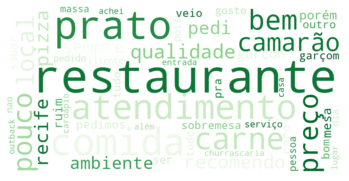

In [57]:
neg_cloud = WordCloud(max_words=50,
                         background_color='white',
                         prefer_horizontal=0.5,
                        width=800,
                        height=400,
                        colormap='Greens').generate(' '.join(neg_reviews))
plt.imshow(neg_cloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud_neg.png')

Well, if you know some portuguese you will realize that the majority of those words are not actually negative. There is some word has appears with low frequency with negative meaning, such as "bad", "therefore", "because".

As we saw that the amount of negative reviews is quite low, the "positive" word cloud problably will not be that much different from the general word cloud that we have already made. So, let's continue with the negative sentiments and make a bar plot with the frequencies.

In [55]:
# Let's calculate Term Frequency manually
TF = []

# This loop itereates through the set of filtered titles. A set is a data structure that stores only unique values
# It calculates how many each unique word appears in the filtered_titles
for word in set(neg_reviews):
    TF.append(neg_reviews.count(word))

# Transforming the set of unique words into a list
terms = list(set(neg_reviews))

# Creating a dataframe out of lists
neg_df_tf = pd.DataFrame(data=list(zip(terms, TF)), columns=['Term', 'Frequency'])
neg_df_tf.sort_values(by='Frequency', ascending=False)

,Term,Frequency
440,comida,524
1190,atendimento,486
1698,restaurante,464
959,bem,386
28,ambiente,250
...,...,...
1674,friademora,2
1677,indo,2
1679,bela,2
1681,hospedado,2


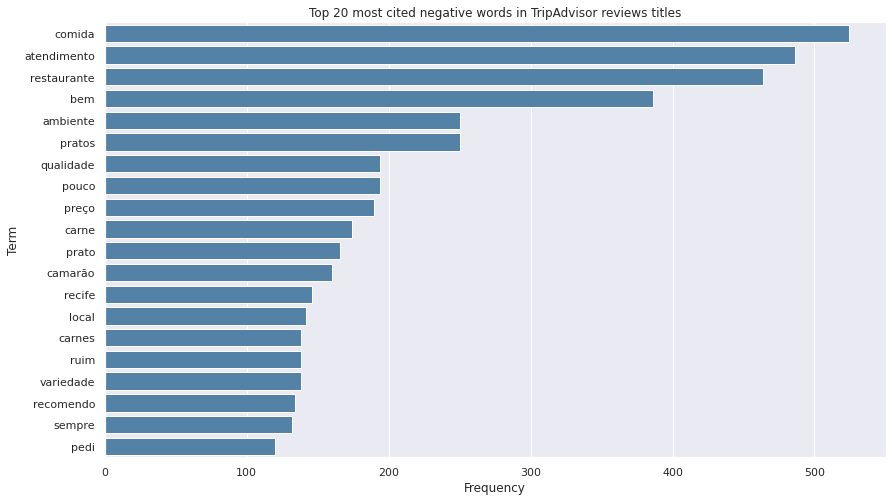

In [56]:
# Now lets redo the bar plot showing the top 20 words
df_tf_top_20 = neg_df_tf.sort_values(by='Frequency', ascending=False)[:20]
fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(data=df_tf_top_20,
           x='Frequency',
           y='Term',
           color='steelblue',
           )
ax.set(title='Top 20 most cited negative words in TripAdvisor reviews titles',
      xlabel='Frequency')
plt.show()

Again, only few of those words carries truly negative feelings.

Maybe this is a problem with the polarity extractor, or problem with the translation or, most probably, the problem is generated when we are tokenizing the words and splitting then. The negative words probably come most in compound phrases, like bigrams and trigramns.